C:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE (2023–Feb 2024): 403.74
RMSE (2023–Feb 2024): 457.30
2023 - MAE: 384.39, RMSE: 437.15
2024 - MAE: 7046.76, RMSE: 8268.22


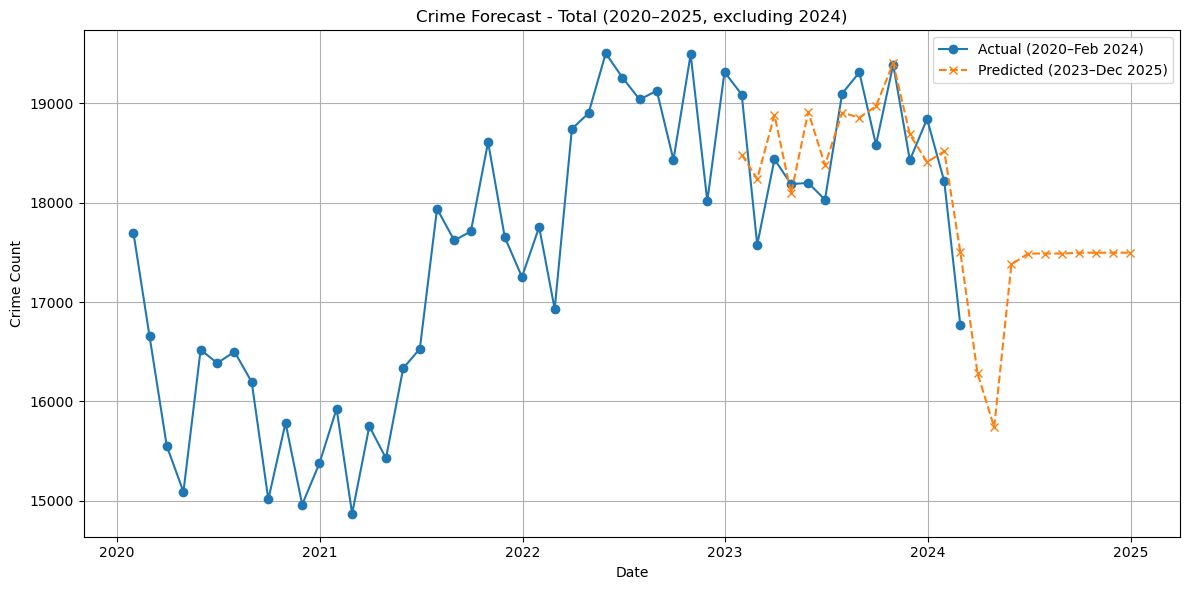

Model saved as C:\Users\I don't know\crime-forecasting\scripts\xgb_crime_model.pkl
2023 forecast saved as C:\Users\I don't know\crime-forecasting\reports\forecast_2023.csv
    Year  Month   date_occ  Actual     Predicted
36  2023      1 2023-01-31   19088  18483.146484
37  2023      2 2023-02-28   17577  18239.060547
38  2023      3 2023-03-31   18436  18882.537109
39  2023      4 2023-04-30   18187  18093.345703
40  2023      5 2023-05-31   18199  18912.642578
41  2023      6 2023-06-30   18030  18377.017578
42  2023      7 2023-07-31   19098  18904.830078
43  2023      8 2023-08-31   19310  18856.029297
44  2023      9 2023-09-30   18582  18970.294922
45  2023     10 2023-10-31   19389  19403.876953
46  2023     11 2023-11-30   18427  18686.005859
47  2023     12 2023-12-31   18843  18407.455078


In [11]:
#!/usr/bin/env python
# coding: utf-8

"""
XGBoost model for crime forecasting (2020–2025).
- Excludes 2024 due to LAPD Records Management System transition issues.
- Trains on reliable 2020–2022 data.
- Predicts for 2023–2025.
"""

import joblib
import pandas as pd
import numpy as np
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os

# =========================
# Load Processed Data
# =========================
BASE_DIR = Path(os.getcwd()).parent  # one folder above current working directory
data_path = BASE_DIR / "data" / "processed" / "cleaned_data.csv"

df = pd.read_csv(data_path)
df.columns = df.columns.str.strip()
df['date_occ'] = pd.to_datetime(df['date_occ'], errors='coerce')
df = df.dropna(subset=['date_occ'])

# =========================
# Feature Engineering
# =========================
monthly_counts = df.groupby(pd.Grouper(key='date_occ', freq='ME')).size().reset_index(name='count')
monthly_counts['year'] = monthly_counts['date_occ'].dt.year
monthly_counts['month'] = monthly_counts['date_occ'].dt.month

# Cyclical encoding for seasonality
monthly_counts['month_sin'] = np.sin(2 * np.pi * monthly_counts['month'] / 12)
monthly_counts['month_cos'] = np.cos(2 * np.pi * monthly_counts['month'] / 12)

# Lag features (1–6 months)
for lag in range(1, 7):
    monthly_counts[f'lag_{lag}'] = monthly_counts['count'].shift(lag).fillna(0)

# Rolling average (3 months)
monthly_counts['rolling_3'] = monthly_counts['count'].rolling(3).mean().fillna(0)

# =========================
# Train / Predict Split
# =========================
train_df = monthly_counts[(monthly_counts['year'] >= 2020) & (monthly_counts['year'] <= 2022)]
predict_df = monthly_counts[monthly_counts['year'] >= 2023]

feature_cols = ['year', 'month', 'month_sin', 'month_cos'] + [f'lag_{i}' for i in range(1, 7)] + ['rolling_3']
X_train = train_df[feature_cols]
y_train = train_df['count']
X_predict = predict_df[feature_cols]
y_actual = predict_df['count']  # for evaluation

# =========================
# Train Model
# =========================
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_predict)

# =========================
# Evaluate Performance
# =========================
# Only months with actuals (up to Feb 2024)
mask_eval = predict_df['date_occ'] <= pd.Timestamp('2024-02-29')
y_true_eval = predict_df.loc[mask_eval, 'count'].values
y_pred_eval = y_pred[mask_eval.values]

mae = mean_absolute_error(y_true_eval, y_pred_eval)
rmse = mean_squared_error(y_true_eval, y_pred_eval, squared=False)

print(f"MAE (2023–Feb 2024): {mae:.2f}")
print(f"RMSE (2023–Feb 2024): {rmse:.2f}")

# Optional: Evaluate MAE/RMSE per year
for yr in [2023, 2024, 2025]:
    mask_year = predict_df['date_occ'].dt.year == yr
    if mask_year.any():
        y_true_y = predict_df.loc[mask_year, 'count'].values
        y_pred_y = y_pred[mask_year.values]
        mae_y = mean_absolute_error(y_true_y, y_pred_y)
        rmse_y = mean_squared_error(y_true_y, y_pred_y, squared=False)
        print(f"{yr} - MAE: {mae_y:.2f}, RMSE: {rmse_y:.2f}")

# =========================
# Visualization
# =========================
mask_actual_plot = monthly_counts['date_occ'] <= pd.Timestamp('2024-02-29')

plt.figure(figsize=(12, 6))
plt.plot(
    monthly_counts.loc[mask_actual_plot, 'date_occ'],
    monthly_counts.loc[mask_actual_plot, 'count'],
    label='Actual (2020–Feb 2024)',
    marker='o'
)
plt.plot(
    predict_df['date_occ'],
    y_pred,
    label='Predicted (2023–Dec 2025)',
    marker='x',
    linestyle='--'
)
plt.title('Crime Forecast - Total (2020–2025, excluding 2024)')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# Save Model + Forecast
# =========================
predict_2023 = predict_df[predict_df['date_occ'].dt.year == 2023].copy()
predict_2023['Predicted'] = y_pred[predict_df['date_occ'].dt.year == 2023]
predict_2023 = predict_2023[['date_occ', 'count', 'Predicted']].rename(columns={'count': 'Actual'})
predict_2023['Year'] = predict_2023['date_occ'].dt.year
predict_2023['Month'] = predict_2023['date_occ'].dt.month
predict_2023 = predict_2023[['Year', 'Month', 'date_occ', 'Actual', 'Predicted']]

model_path = BASE_DIR / "scripts" / "xgb_crime_model.pkl"
joblib.dump(model, model_path)
print(f"Model saved as {model_path}")

forecast_path = BASE_DIR / "reports" / "forecast_2023.csv"
predict_2023.to_csv(forecast_path, index=False)
print(f"2023 forecast saved as {forecast_path}")

print(predict_2023)

# =========================
# Utility functions
# =========================
def load_model(model_path: Path):
    return joblib.load(model_path)

def predict_model(model, X):
    return model.predict(X)